In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split,
from sklearn.metrics import confusion_matrix
import io

%matplotlib inline

rc={'figure.figsize':(10,10),"font.size":25,"axes.titlesize":25,"axes.labelsize":20}
sns.set(font_scale=2,rc=rc,style="white",context='notebook')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import elm

In [ ]:
df = pd.read_csv (r'winequalityN.csv')

In [ ]:
df.describe()

fixed acidity  volatile acidity  ...      alcohol      quality
count    6487.000000       6489.000000  ...  6497.000000  6497.000000
mean        7.216579          0.339691  ...    10.491801     5.818378
std         1.296750          0.164649  ...     1.192712     0.873255
min         3.800000          0.080000  ...     8.000000     3.000000
25%         6.400000          0.230000  ...     9.500000     5.000000
50%         7.000000          0.290000  ...    10.300000     6.000000
75%         7.700000          0.400000  ...    11.300000     6.000000
max        15.900000          1.580000  ...    14.900000     9.000000

[8 rows x 12 columns]

In [ ]:
n = df[df.isnull().values == True].shape[0]
bad_row_frac = round(n/float(df.shape[0]),2)
print("There are {} rows (~ {}% of data) with at least one missing cell.".format(n,bad_row_frac))


thresh = 0.03
if bad_row_frac < thresh:
    print("Removing rows with missing values...")
    df.drop(df[df.isnull().values == True].index,inplace=True)

There are 38 rows (~ 0.01% of data) with at least one missing cell.
Removing rows with missing values...


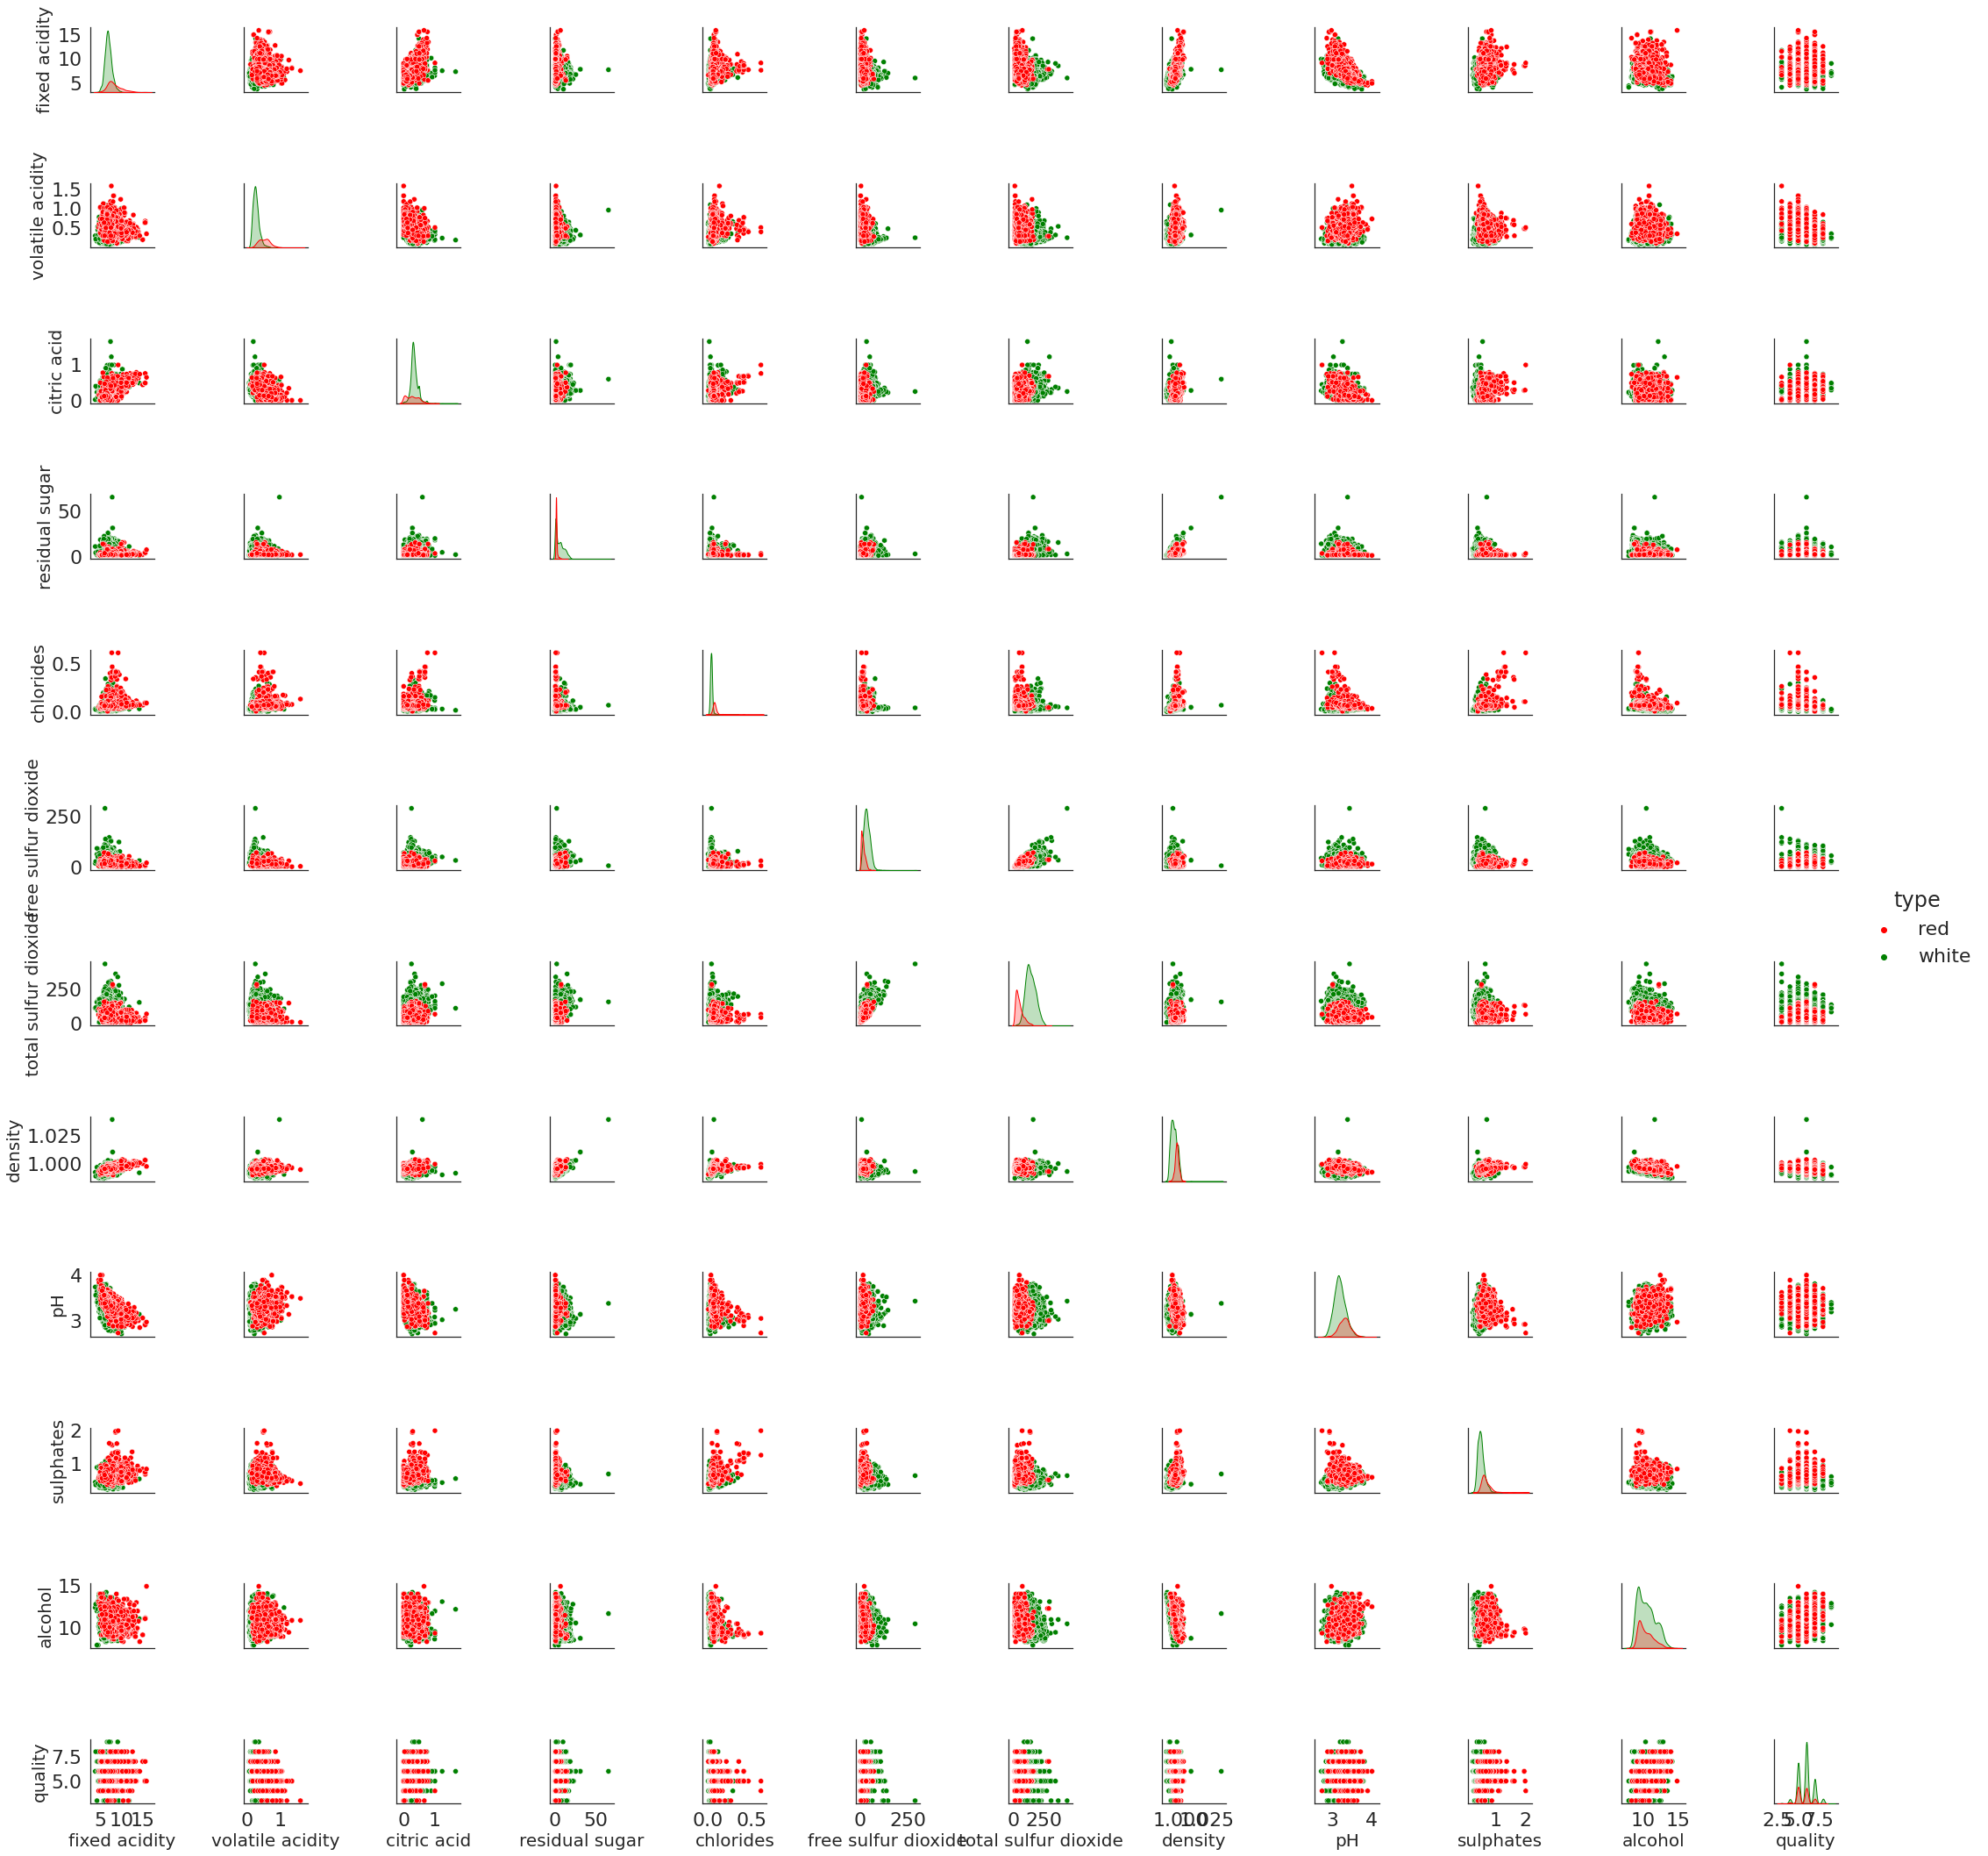

In [ ]:
sns.pairplot(df,hue='type',hue_order=['red','white'],palette=['red','green'])

In [ ]:
plt.figure(figsize=[10,10],dpi=2000)
sns.heatmap(df.corr(),cmap='coolwarm',linewidth=2,annot=True,annot_kws={'fontsize':10})

In [ ]:
print(df['type'])

0       white
1       white
2       white
3       white
4       white
        ...  
6492      red
6493      red
6494      red
6495      red
6496      red
Name: type, Length: 6497, dtype: object


In [ ]:
df['type'] = pd.factorize(df['type'])[0] + 1
print(df['type'])

0       1
1       1
2       1
3       1
4       1
       ..
6491    2
6492    2
6494    2
6495    2
6496    2
Name: type, Length: 6463, dtype: int64


In [ ]:
data = df.to_numpy()

In [ ]:
y = data[:,:1]
x = data[:,2:]

In [ ]:
print(x.shape)

(6497, 11)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
y

array([['white'],
       ['white'],
       ['white'],
       ...,
       ['red'],
       ['red'],
       ['red']], dtype=object)

In [ ]:

elm = ELM(hid_num=5).fit(X_train, y_train)

print("ELM Accuracy %0.3f " % elm.score(X_test, y_test))


ELM Accuracy 0.775 


In [ ]:
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin


class ELM (BaseEstimator, ClassifierMixin):



    def __init__(self,
                 hid_num,
                 a=1):

        self.hid_num = hid_num
        self.a = a

    def _sigmoid(self, x):

        sigmoid_range = 34.538776394910684
        x = np.clip(x, -sigmoid_range, sigmoid_range)
        return 1 / (1 + np.exp(-self.a * x))

    def _add_bias(self, X):

        return np.c_[X, np.ones(X.shape[0])]

    def _ltov(self, n, label):

        return [-1 if i != label else 1 for i in range(1, n + 1)]

    def fit(self, X, y):

        # number of class, number of output neuron
        self.out_num = max(y)

        if self.out_num != 1:
            y = np.array([self._ltov(self.out_num, _y) for _y in y])

        # add bias to feature vectors
        X = self._add_bias(X)

        # generate weights between input layer and hidden layer
        np.random.seed()
        self.W = np.random.uniform(-1., 1.,
                                   (self.hid_num, X.shape[1]))

        # find inverse weight matrix
        _H = np.linalg.pinv(self._sigmoid(np.dot(self.W, X.T)))

        self.beta = np.dot(_H.T, y)

        return self

    def predict(self, X):

        _H = self._sigmoid(np.dot(self.W, self._add_bias(X).T))
        y = np.dot(_H.T, self.beta)

        if self.out_num == 1:
            return np.sign(y)
        else:
            return np.argmax(y, 1) + np.ones(y.shape[0])


def main():
    from sklearn import preprocessing
    from sklearn.datasets import fetch_openml as fetch_mldata
    from sklearn.model_selection import ShuffleSplit, KFold, cross_val_score

    db_name = 'australian'
    hid_nums = [100, 200, 300]

    data_set = fetch_mldata(db_name)
    data_set.data = preprocessing.normalize(data_set.data)
    data_set.target = [1 if i == 1 else -1
                       for i in  data_set.target.astype(int)]

    for hid_num in hid_nums:
        print(hid_num, end=' ')
        e = ELM(hid_num)

        ave = 0
        for i in range(10):
            cv = KFold(n_splits=5, shuffle=True)
            scores = cross_val_score(
                e, data_set.data, data_set.target,
                cv=cv, scoring='accuracy', n_jobs=-1)
            ave += scores.mean()

        ave /= 10

        print("Accuracy: %0.3f " % (ave))


if __name__ == "__main__":
    import doctest
    doctest.testmod()
    main()


100 Accuracy: 0.820 
200 Accuracy: 0.808 
300 Accuracy: 0.772 
